## Calculate temperature profiles under different modelling assumptions

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../../"))
if !haskey(ENV, "RAD_DIR")
    ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")
end
println(ROOT_DIR)

/home2/p321409/Projects/AGNI/


In [2]:
# Import system packages
using Pkg
using Printf
using DelimitedFiles
using Plots
default(label=nothing, grid=true)

using LaTeXStrings

In [3]:
# Import AGNI
Pkg.activate(ROOT_DIR)
using AGNI

# Normal logging from AGNI module
AGNI.setup_logging("",1)

  Activating project at `~/Projects/AGNI`


In [4]:
R_earth = 6.371e6 # m
S_earth = 1361.0 # W/m^2

1361.0

### Define atmosphere parameters

In [24]:
# Configuration options
instellation    = 2 * S_earth / 0.723^2 # Double venus instellation flux
println("S = $instellation W/m^2")

gravity         = 9.81
radius          = 1 * R_earth
zenith          = 54.74
albedo          = 0.0
s0_fact         = 0.25
nlev_centre     = 45
p_surf          = 1e4     # bar
t_surf          = 1300.0    # solidus
p_top           = 1e-4      # bar


Z = 1.0 # metallicity
xH2O = 2 * (1.0 / 16.0) * Z  # calc xH2O from metallicity, assuming H2O+H2 only
mole_fractions  = Dict([ ("H2O", xH2O), ("H2", 1-xH2O)])
println(mole_fractions)

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Dayspring/48/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt");

# Create output directory
output_dir = joinpath(ROOT_DIR,"out")
rm(output_dir,force=true,recursive=true)
mkdir(output_dir)
println(output_dir)

S = 5207.287141138142 W/m^2
Dict("H2O" => 0.125, "H2" => 0.875)
/home2/p321409/Projects/AGNI/out


### Initialise the atmosphere

In [6]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, s0_fact, albedo, zenith,
                        t_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=false,
                        thermo_functions=true
                        )
atmosphere.allocate!(atmos, star_file)
setpt.loglinear!(atmos, "Teq")
println("Done!")

[ INFO  ] Setting-up a new atmosphere struct
[ INFO  ] Loading thermodynamic data
[ INFO  ] Inserting stellar spectrum
[ INFO  ] Allocating atmosphere with initial composition:
[ INFO  ]       1 H2O     1.25e-02 (EOS_AQUA)
[ INFO  ]       2 H2      9.88e-01 (EOS_CMS19)
Done!


In [7]:
for (g,x) in mole_fractions
    fill!(atmos.gas_ovmr[g], x)
    fill!(atmos.gas_vmr[g],  x)
    println("Gas $g = $(atmos.gas_ovmr[g][end])")
end

Gas H2O = 0.0125
Gas H2 = 0.9875


In [8]:
atmos_results::Dict{String, atmosphere.Atmos_t} = Dict{String, atmosphere.Atmos_t}()

Dict{String, AGNI.atmosphere.Atmos_t}()

## Run the model under various scenarios

In [9]:
atmosphere.HYDROGRAV_constg   = false     # constant gravity with height?
atmosphere.HYDROGRAV_selfg    = true     # include self-gravity of the atmosphere?
atmosphere.HYDROGRAV_steps    = 8000    # number of levels for hydrostatic integration
atmosphere.HYDROGRAV_maxdr    = 1e9      # max dr across each level
atmosphere.HYDROGRAV_ming     = 1e-30   # min gravity

println(atmosphere.HYDROGRAV_constg)
println(atmosphere.HYDROGRAV_selfg)
println(atmosphere.HYDROGRAV_steps)
println(atmosphere.HYDROGRAV_maxdr)
println(atmosphere.HYDROGRAV_ming)

false
true
8000
1.0e9
1.0e-30


### Fixed surface temperature

In [10]:
atmos.tmp_surf = deepcopy(t_surf)
println(atmos.tmp_surf)

1300.0


In [ ]:
# Isothermal
setpt.isothermal!(atmos, atmos.tmp_surf)
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos; radiative=true, convective=true)
atmosphere.calc_observed_rho!(atmos)
atmos_results["T_Iso"] = deepcopy(atmos)
all(isfinite.(atmos.flux_n))

true

In [ ]:
# Adiabatic
setpt.dry_adiabat!(atmos)
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos; radiative=true, convective=true)
atmosphere.calc_observed_rho!(atmos)
atmos_results["T_Ad"] = deepcopy(atmos)
all(isfinite.(atmos.flux_n))

true

In [ ]:
# Adiabatic + stratosphere
setpt.dry_adiabat!(atmos)
setpt.stratosphere!(atmos, phys.calc_Tskin(atmos.instellation, atmos.albedo_b))
atmosphere.calc_layer_props!(atmos)
energy.calc_fluxes!(atmos; radiative=true, convective=true)
atmosphere.calc_observed_rho!(atmos)
atmos_results["T_AdS"] = deepcopy(atmos)
all(isfinite.(atmos.flux_n))

true

In [14]:
# Radiative-convective
setpt.loglinear!(atmos, 1000) # initial guess
succ = solver.solve_energy!(atmos,
                                    sol_type=1,
                                    method=1,
                                    dx_max=400.0,
                                    ls_method=2,
                                    modplot=0,
                                    save_frames=false,
                                    detect_plateau=true
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["T_RCE"] = deepcopy(atmos)
all(isfinite.(atmos.flux_n))

[ INFO  ]     sol_type  = 1
[ INFO  ]     tmp_surf  = 1300.00 K
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags
[ WARN  ]        1  -2.56e-02  5.628e+04  5.679e+04  1.300e+03  3.579e-03  Cs-C2-Ls-Ub
[ WARN  ]        2  +1.18e-04  1.432e+04  1.716e+04  1.300e+03  3.579e+02  Cs-C2-Ub
[ INFO  ]        3  +8.64e-03  7.675e+03  1.122e+04  1.300e+03  1.980e+02  Cs-C2-Ls
[ WARN  ]        4  +3.14e-03  1.211e+04  1.195e+04  1.300e+03  1.980e+02  Cs-C2-Ls-Ub
[ INFO  ]        5  +7.23e-04  3.239e+07  4.972e+03  1.300e+03  9.609e+01  Cs-C2-Ls
[ INFO  ]        6  +2.13e-03  1.545e+07  3.676e+03  1.307e+03  1.980e+02  Cs-C2-Ls
[ INFO  ]        7  -3.84e-03  1.015e+07  2.301e+03  1.366e+03  1.034e+02  Cs-C2-Ls
[ INFO  ]        8  -6.04e-03  1.497e+07  1.435e+03  1.385e+03  6.640e+01  Cs-C2-Ls
[ INFO  ]        9  -1.41e-02  1.847e+07  9.867e+02  1.411e+03  7.386e+01  Cs-C2-Ls
[ INFO  ]       10  -6.73e-02  4.092e+06  5.197e+02  1.374e+03  7.851e+01  Cs-C2
[ INFO  ]  

InterruptException: InterruptException:

### Solving for energy balance

In [15]:
# Isothermal
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=1, tmp_upper=1000.0)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["F_Iso"] = deepcopy(atmos)
;

[ INFO  ]     total flux         = +1.57e-02 W m-2     
[ INFO  ]     surf temperature   = 285.321   K        
[ INFO  ]     surf pressure      = 1.0e+04 bar      
Solver success? true


In [16]:
# Adiabatic
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=2)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["F_Ad"] = deepcopy(atmos)
;

[ WARN  ] GS search did not converge
[ INFO  ]     total flux         = -3.70e+02 W m-2     
[ INFO  ]     surf temperature   = 3622.755  K        
[ INFO  ]     surf pressure      = 1.0e+04 bar      
Solver success? false


In [17]:
# Adiabatic + stratosphere
succ = solver.solve_prescribed!(atmos, sol_type=3, atm_type=3)
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["F_AdS"] = deepcopy(atmos)
;

[ WARN  ] GS search did not converge
[ INFO  ]     total flux         = -5.03e+01 W m-2     
[ INFO  ]     surf temperature   = 3608.021  K        
[ INFO  ]     surf pressure      = 1.0e+04 bar      
Solver success? false


In [18]:
# Radiative-convective
setpt.isothermal!(atmos, t_surf) # initial guess
succ = solver.solve_energy!(atmos,
                                    sol_type=3,
                                    method=1,
                                    dx_max=400.0,
                                    ls_method=2,
                                    modplot=0,
                                    save_frames=false,
                                    detect_plateau=true
                                    )
println("Solver success? $succ")
atmosphere.calc_observed_rho!(atmos)
atmos_results["F_RCE"] = deepcopy(atmos)
;

[ INFO  ]     sol_type  = 3
[ INFO  ]     flux_int  = 0.00 W m-2
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags
[ WARN  ]        1  +2.53e-05  1.692e+05  1.619e+05  1.301e+03  3.196e-03  Cs-C2-Ls-Ub
[ WARN  ]        2  -2.40e-08  5.062e+04  5.136e+04  1.211e+03  3.196e+02  Cs-C2-Ub
[ INFO  ]        3  +1.97e-07  1.367e+04  2.267e+04  8.224e+02  4.000e+02  Cs-C2
[ INFO  ]        4  +2.66e-07  5.406e+03  1.677e+04  1.222e+03  4.000e+02  Cs-C2
[ INFO  ]        5  -3.47e+00  7.617e+10  1.651e+04  1.242e+03  1.980e+02  Cs-C2-Ls
[ INFO  ]        6  -2.84e+01  1.099e+11  1.604e+04  1.258e+03  1.980e+02  Cs-C2-Ls
[ INFO  ]        7  -5.00e+01  1.391e+11  1.532e+04  1.266e+03  1.980e+02  Cs-C2-Ls
[ INFO  ]        8  -4.14e+00  1.580e+11  1.488e+04  1.280e+03  1.980e+02  Cs-C2-Ls
[ INFO  ]        9  -4.14e+00  1.580e+11  1.488e+04  1.280e+03  4.000e-03  Cs-C2-Ls
[ INFO  ]       10  -4.14e+00  1.580e+11  1.488e+04  1.280e+03  4.000e-03  Cs-C2-Ls
[ INFO  ]       

[ ERROR ]     failure (singular jacobian)
[ INFO  ]     total flux at TOA  = +1.62e+03 W m-2     
[ INFO  ]     total flux at BOA  = -2.37e+03 W m-2     
[ INFO  ]     global flux loss   = +3.29e+11 W m-2  (+1.00e+02 %) 
[ INFO  ]     surf temperature   = 309.818   K        
[ INFO  ]     surf pressure      = 1.000e+04 bar      


Solver success? false


In [19]:
# save to netcdf
for (k,atm) in atmos_results
    save.write_ncdf(atm, joinpath(output_dir,k*".nc"))
end


In [20]:
fig1 = plot(size=(520,580), frame=:box,
            legend=:outertop, legendcolumns=2, legendfontsize=10,
            ylabel=L"Radius [R$_\oplus$]",
            right_margin = 2Plots.mm, bottom_margin=  -3Plots.mm,
            xlabel="Temperature [K]", labelfontsize=11, tickfontsize=11)

lw0 = 1.5

Teqm = phys.calc_Tskin(atmos.instellation, atmos.albedo_b)
# vline!(fig1, [Teqm], ls=:dash, color=:palegreen, lw=lw, label=@sprintf("Skin temperature"))

# default axis limits
y_min = 10.0
y_max = 0.5
x_min = -1
x_max = 10.0


lstyles = Dict([("Iso",:dot), ("Ad",:dashdotdot), ("AdS",:dash), ("RCE",:solid)])
lwidths = Dict([("Iso",1),    ("Ad",1),           ("AdS",2),     ("RCE",2)])

# plot
for (k,atm) in atmos_results

    spl = split(k,"_")

    # line label and color
    if spl[1] == "1"
        col = "orangered"
    else
        col = "dodgerblue"
    end
    ls = lstyles[spl[2]]
    lw = lwidths[spl[2]] * lw0

    # plot profile
    plot!(fig1, atm.tmp, atm.r / R_earth, lw=lw, linestyle=ls, color=col)

    # plot photosphere point
    atmosphere.calc_observed_rho!(atm)
    rtrans = atm.transspec_r/R_earth
    # plot!(fig, [x_min, atm.transspec_tmp], [rtrans,rtrans], color=col, linealpha=0.5, linestyle=ls)
    scatter!(fig1, [atm.transspec_tmp], [rtrans], color=col)
    # scatter!(fig, [x_min], [rtrans], color=col)

    # axis limits
    y_min = min( minimum(atm.r) / R_earth, y_min)
    y_max = max( rtrans, y_max)
    x_max = max( maximum(atm.tmp), x_max)
end

# legend entries
llw = 2
# scatter!(fig1, [], [], label="Transit radius", color=:grey, markersize=6)
plot!(fig1, [], [], lw=llw, label="BC=Tsurf",   lc="orangered",  ls=:solid,  )
plot!(fig1, [], [], lw=llw, label="BC=Fint",    lc="dodgerblue", ls=:solid,  )
plot!(fig1, [], [],         label="TP=Iso",     lc="black",      ls=lstyles["Iso"], lw=lwidths["Iso"]  )
plot!(fig1, [], [],         label="TP=Adi",     lc="black",      ls=lstyles["Ad"], lw=lwidths["Ad"]  )
plot!(fig1, [], [],         label="TP=Adi+Str", lc="black",      ls=lstyles["AdS"], lw=lwidths["AdS"]  )
plot!(fig1, [], [],         label="TP=RCE",     lc="black",      ls=lstyles["RCE"], lw=lwidths["RCE"]  )

y_max = 5.0
y_tck = 0.5
yaxis!(ylim=(1.0, y_max), yticks=range(1.0, y_max, step=y_tck))

x_tck = 250.0
xaxis!(xlim=(x_min, x_max), xticks=range(0.0, x_max, step=x_tck))

display(fig1)

KeyError: KeyError: key "ad+strat" not found

In [21]:
fig2 = plot(legend=:right, size=(520,150),
            ylabel=L"R$_p$ / R$_\oplus$",
            left_margin = 4Plots.mm,
            labelfontsize=11, tickfontsize=11, frame=:box)

# plot
y = Float64[]
x = Float64[]
c = String[]
s = Symbol[]
l = String[]
i = 0
for spl1 in ["1","3"]
    for spl2 in ["iso","ad","ad+strat","radconv"]
        i += 1

        # line label and color
        if spl1 == "1"
            col = "orangered"
            ann = "T"
        elseif spl1 == "3"
            col = "dodgerblue"
            ann = "F"
        end

        if spl2 == "iso"
            lbl = "Iso"
        elseif spl2 == "radconv"
            lbl = "RCE"
        elseif spl2 == "ad"
            lbl = "Ad"
        elseif spl2 == "ad+strat"
            lbl = "Ad+S"
        end

        ls = lstyles[spl2]

        k = "$(spl1)_$(spl2)"

        # add photosphere point
        yy = atmos_results[k].transspec_r/R_earth
        push!(y, yy)
        push!(x, i)
        push!(c, col)
        push!(s, ls)
        push!(l, lbl)

        annotate!(fig2, i, yy, (ann,:bottom, 12))
    end
end

bar!(fig2, x, y, linestyle=s, fillcolor=c, linewidth=1.5)

xaxis!(xticks=(x,l))
yaxis!(ylim=(1,y_max+0.1))

display(fig2)

KeyError: KeyError: key "iso" not found

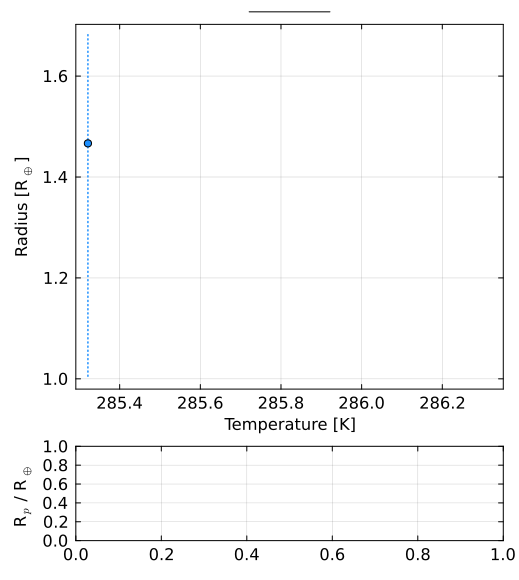

"/home2/p321409/Projects/AGNI/out/atmosphere.pdf"

In [22]:
figN = plot(fig1,fig2; layout=grid(2,1, heights=(0.8,0.2)))
display(figN)
savefig(figN, joinpath(output_dir,"atmosphere.pdf"))